# Artigo 7
* Aluno: Paulo Henrique Costa Gontijo
* Matrícula: 15/0143800
* Lição: **
* Notebooks: 
  * **
  * **

| Hitórico de versão | Data |
|:--------------------:|:------:|
| v1 | 24/01/2023 |

## Propósito
Este artigo tem a intenção de documentar o passo a passo da quarta lição do curso, mostrando os blocos de códigos, o resultado das execuções, eventuais problemas encontrados e, se houver, as possíveis soluções para os problemas.

## Tema
A lição 7 do curso FastAi contempla conceitos como Filtro Colaborativo, viés de usuário e produto. Dentre estes tópicos, são apresentadas técnicas de análise e treinamento de modelos específico para o tema.

In [1]:
import fastbook
fastbook.setup_book()

## Importação das Bibliotecas

In [2]:
import os
import pandas as pd

file_name = 'train.jsonl'
file_path = '/'.join([os.getcwd(), file_name])

## Criando Cluster Spark

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

    # init session
spark = SparkSession \
        .builder \
        .appName("otto-reccomender-competition-kaggle") \
        .config("spark.sql.warehouse.dir", abspath('spark-warehouse')) \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true")\
        .config("spark.driver.maxResultSize", "20g")\
        .enableHiveSupport() \
        .getOrCreate()

# show configured parameters
print(SparkConf().getAll())

# set log level
spark.sparkContext.setLogLevel("FATAL")

23/02/01 17:41:55 WARN Utils: Your hostname, gobellek-B660M-DS3H-DDR4 resolves to a loopback address: 127.0.1.1; using 192.168.0.37 instead (on interface enp3s0)
23/02/01 17:41:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/01 17:41:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
[('spark.app.name', 'otto-reccomender-competition-kaggle'), ('spark.app.submitTime', '1675284115898'), ('spark.sql.execution.arrow.pyspark.fallback.enabled', 'true'), ('spark.sql.catalogImplementation', 'hive'), ('spark.driver.maxResultSize', '20g'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.sql.warehouse.dir', '/home/gobellek/Documents/UnB/mlops/fastaiOnCampus/artigos/lesson-7/spark-warehouse'), ('spark.ui.showConsoleProgress', 'true'), ('spark.sql.execution.arrow.pyspark.enabled', 'true')]


* Conferindo o instanciamento

In [4]:
spark

In [5]:
import pyspark.pandas as ps
ps.set_option('compute.ops_on_diff_frames', True)

* Leitura do arquivo disponibilizado na competição kaggle: [link.](https://www.kaggle.com/competitions/otto-recommender-system/overview/)

In [6]:
df_raw = spark.read \
    .format("json") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .json(file_path)
df_raw.columns

['events', 'session']

* Conferindo número de partições e conteúdo

In [7]:
print(df_raw.rdd.getNumPartitions())

85


In [8]:
df_raw.show(10)

+--------------------+-------+
|              events|session|
+--------------------+-------+
|[{1517085, 165930...|      0|
|[{424964, 1659304...|      1|
|[{763743, 1659304...|      2|
|[{1425967, 165930...|      3|
|[{613619, 1659304...|      4|
|[{1098089, 165930...|      5|
|[{137164, 1659304...|      6|
|[{87774, 16593048...|      7|
|[{1814223, 165930...|      8|
|[{847707, 1659304...|      9|
+--------------------+-------+
only showing top 10 rows



* Contagem de linhas em arquivo bruto

In [9]:
df_raw.count()

12899779

In [10]:
df_raw.printSchema()

root
 |-- events: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- aid: long (nullable = true)
 |    |    |-- ts: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- session: long (nullable = true)



* Processamento de Json para formato tabular

In [11]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
df_explode = df_raw.withColumn('events_explode', F.explode('events'))\
                    .withColumn('session', F.col('session').cast(T.IntegerType()))\
                    .withColumn('aid', F.col('events_explode.aid').cast(T.IntegerType()))\
                    .withColumn('ts', F.col('events_explode.ts'))\
                    .withColumn('type', F.col('events_explode.type'))\
                    .drop('events', 'events_explode')
df_explode.show(10)

+-------+-------+-------------+------+
|session|    aid|           ts|  type|
+-------+-------+-------------+------+
|      0|1517085|1659304800025|clicks|
|      0|1563459|1659304904511|clicks|
|      0|1309446|1659367439426|clicks|
|      0|  16246|1659367719997|clicks|
|      0|1781822|1659367871344|clicks|
|      0|1152674|1659367885796|clicks|
|      0|1649869|1659369893840| carts|
|      0| 461689|1659369898050| carts|
|      0| 305831|1659370027105|orders|
|      0| 461689|1659370027105|orders|
+-------+-------+-------------+------+
only showing top 10 rows



* Contagem de linhas após o tratamento

In [12]:
df_explode.count()

216716096

* Schema pós tratamento

In [13]:
df_explode.printSchema()

root
 |-- session: integer (nullable = true)
 |-- aid: integer (nullable = true)
 |-- ts: long (nullable = true)
 |-- type: string (nullable = true)



* Categorização de coluna alvo string

In [14]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='type', outputCol='type_cat')
indexer_fitted = indexer.fit(df_explode)
df_indexed = indexer_fitted.transform(df_explode)
df_indexed = df_indexed.withColumn('type_cat', F.col('type_cat').cast(T.IntegerType())).drop('type')
df_indexed = df_indexed.drop('ts')
df_indexed.show(10)

+-------+-------+--------+
|session|    aid|type_cat|
+-------+-------+--------+
|      0|1517085|       0|
|      0|1563459|       0|
|      0|1309446|       0|
|      0|  16246|       0|
|      0|1781822|       0|
|      0|1152674|       0|
|      0|1649869|       1|
|      0| 461689|       1|
|      0| 305831|       2|
|      0| 461689|       2|
+-------+-------+--------+
only showing top 10 rows



* Conferência de schema pós tratativas

In [15]:
df_indexed.printSchema()

root
 |-- session: integer (nullable = true)
 |-- aid: integer (nullable = true)
 |-- type_cat: integer (nullable = true)



* Estatísticas em amostra

In [16]:
df_indexed.describe().show()

+-------+-----------------+-----------------+-------------------+
|summary|          session|              aid|           type_cat|
+-------+-----------------+-----------------+-------------------+
|  count|        216716096|        216716096|          216716096|
|   mean|4702787.036247751|928805.2291050315|0.12502113825453925|
| stddev|3664999.505174937|536691.7477821864|0.39553426995921603|
|    min|                0|                0|                  0|
|    max|         12899778|          1855602|                  2|
+-------+-----------------+-----------------+-------------------+



## Análise de Clientes

* Quantidade de clientes únicos

In [17]:
df_indexed.select('session').distinct().count()

12899779

* Clientes que mais interagiram

In [18]:
df_indexed.groupby(df_indexed.session).agg(F.count("*").alias('count')).orderBy(F.col("count").desc()).show()

+--------+-----+
| session|count|
+--------+-----+
| 6265682|  500|
| 4110619|  500|
|10776795|  499|
| 1870739|  499|
|  352795|  498|
|11361393|  498|
| 2473055|  498|
|  715022|  498|
| 3043807|  497|
| 1166020|  497|
| 5611645|  497|
|  584209|  497|
| 1637995|  497|
| 1005706|  496|
| 1181850|  495|
|    7905|  495|
|  767281|  495|
| 5194281|  495|
| 1605395|  495|
| 2310563|  495|
+--------+-----+
only showing top 20 rows



* Clientes que mais compraram

In [19]:
df_indexed.filter("type_cat==2").groupBy('session').agg(F.count('type_cat').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|session|count|
+-------+-----+
| 632727|  117|
|6247320|  103|
| 473286|  100|
| 537589|   98|
|5408461|   94|
| 270870|   91|
| 928030|   91|
|6118385|   90|
|  29693|   89|
| 125743|   88|
| 229448|   88|
|2077637|   87|
| 521545|   86|
|8643943|   86|
|2845568|   85|
|6691353|   85|
|1471672|   85|
|5530900|   83|
|1401588|   81|
|1572771|   81|
+-------+-----+
only showing top 20 rows



## Análise de Produtos

* Quantidade de produtos únicos

In [20]:
df_indexed.select('aid').distinct().count()

1855603

* Produtos mais comprados

In [21]:
df_indexed.filter("type_cat==2").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 231487| 4485|
| 166037| 3824|
|1733943| 3042|
|1445562| 2998|
|1022566| 2788|
| 801774| 2710|
|1629608| 2628|
| 756588| 2593|
| 332654| 2436|
|1603001| 2353|
| 409620| 2329|
|1257293| 2273|
|1125638| 2203|
| 986164| 2192|
|1083665| 2174|
| 450505| 2137|
| 544144| 2096|
|1025795| 2071|
| 125278| 2047|
|  29735| 2007|
+-------+-----+
only showing top 20 rows



* Produtos mais colocados em carrinho

In [22]:
df_indexed.filter("type_cat==1").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+-----+
|    aid|count|
+-------+-----+
| 485256|29682|
| 152547|18536|
|  33343|14726|
| 166037|13476|
|1733943|10654|
| 231487|10393|
|  29735|10124|
|1022566| 9338|
| 832192| 8626|
| 544144| 7407|
| 554660| 7336|
| 322370| 7298|
|1562705| 7128|
| 986164| 7005|
|1083665| 6734|
| 332654| 6679|
|1629608| 6659|
|1236775| 6224|
| 756588| 6166|
| 613493| 6111|
+-------+-----+
only showing top 20 rows



* Produtos mais clicados

In [23]:
df_indexed.filter("type_cat==0").groupBy('aid').agg(F.count('*').alias('count')).orderBy(F.col('count').desc()).show()

+-------+------+
|    aid| count|
+-------+------+
|1460571|121287|
| 108125|114456|
|  29735|101148|
| 485256| 97154|
|1733943| 91395|
| 184976| 85122|
| 832192| 81127|
|1502122| 73805|
| 554660| 72161|
|1603001| 68519|
| 986164| 67791|
| 166037| 67357|
| 322370| 66729|
|1236775| 66076|
| 231487| 64994|
| 959208| 63034|
| 332654| 62617|
|1196256| 62221|
|  95488| 62023|
| 620545| 60816|
+-------+------+
only showing top 20 rows



* Escrita do dataset, em formato CSV, em única partição

In [24]:
# df_indexed.coalesce(1)\
#         .write.format('csv')\
#         .option("header", "True")\
#         .mode("overwrite")\
#         .save('/'.join([os.getcwd(), 'test.csv']))

spark.stop()

## Colaborative Filtering


* Função para listar arquivos em pasta com prefixo .csv

In [25]:
def list_csv_in_dir(path):
    dir_path = '/'.join([os.getcwd(), path])
    list_files = []
    for path in os.scandir(dir_path):
        if path.is_file():
            if path.name.endswith('.csv'):
                list_files.append(path.name)
    return list_files
list_files = list_csv_in_dir('data.csv')
list_files

['part-00001-e6bfdd99-73da-4ebc-a420-d71150c63f00-c000.csv',
 'part-00000-e6bfdd99-73da-4ebc-a420-d71150c63f00-c000.csv']

* Leitura dos dados em um DataFrame

In [27]:
path = '/'.join([os.getcwd(),'data.csv',list_files[0]])
df = pd.read_csv(filepath_or_buffer=path, nrows=2000000)
df = df.fillna(df.mode().iloc[0])
df.head(20)

,session,aid,type_cat
0,3983334,1668263,0
1,3983334,198635,0
2,3983334,75856,0
3,3983334,559635,0
4,3983335,1019238,0
5,3983335,1672025,0
6,3983335,1500899,0
7,3983335,1628617,0
8,3983335,246358,0
9,3983335,1628617,0


* Reposicionando colunas para se adequar ao padrão do framework Fastai

In [28]:
df = df[['session', 'aid', 'type_cat']]

* Dividindo o Dataset em treino e teste

In [29]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=104)
del df

In [30]:
train_df.head()

,session,aid,type_cat
371119,4002966,933530,0
1859605,4084066,1737348,0
218841,3995283,688602,0
606372,4015536,285096,0
1538856,4066733,206561,0


In [31]:
test_df.head()

,session,aid,type_cat
68860,3987145,1224794,1
962017,4034883,419628,0
1186264,4047485,416172,0
302814,3999536,231487,0
803153,4026200,1685214,0


* Carga em CollabDLS

In [32]:
from fastai.collab import *
dls = CollabDataLoaders.from_df(train_df, item_name='aid', bs=1024)
dls.train.show_batch()

,session,aid,type_cat
0,4029609,46400,2
1,4026130,1537866,0
2,4004682,1560585,0
3,4062727,967233,1
4,4086185,194308,0
5,3985752,1573047,0
6,4043501,221265,1
7,4074386,385065,0
8,4009100,1604220,0
9,4011536,1164435,0


In [33]:
str(dls.classes)[:200]

"{'session': ['#na#', 3983334, 3983335, 3983336, 3983337, 3983338, 3983339, 3983340, 3983341, 3983342, 3983343, 3983344, 3983345, 3983346, 3983347, 3983348, 3983349, 3983350, 3983351, 3983352, 3983353,"

* Sugestão de taxa de aprendizado

SuggestedLRs(valley=0.02290867641568184)
Learning Rate:  0.02290867641568184


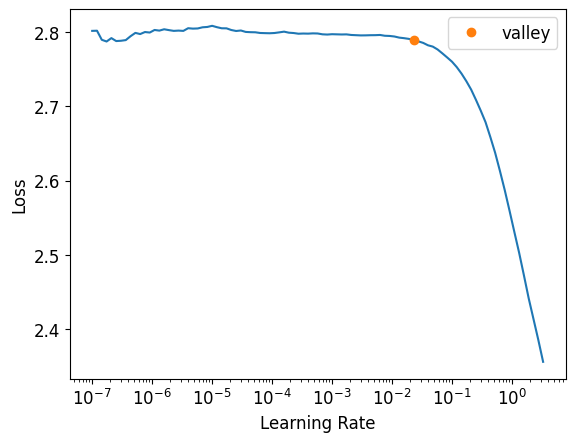

In [35]:
learn = collab_learner(dls, n_factors=5, y_range=(0, 3.5))
lr_rate = learn.lr_find()
print(lr_rate)
lr=(lr_rate[0])
print('Learning Rate: ',lr)

* Treinamento do modelo

In [37]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,time
0,0.363568,0.443931,00:13
1,0.250039,0.305049,00:15
2,0.187528,0.270822,00:19
3,0.156639,0.266532,00:18
4,0.140322,0.266607,00:19
5,0.128551,0.266973,00:18
6,0.118113,0.269231,00:16
7,0.108440,0.271916,00:14
8,0.096966,0.273762,00:13
9,0.091332,0.274051,00:11


* Resultado do treinamento

In [41]:
learn.show_results()

,session,aid,type_cat,type_cat_pred
0,85856,108414,0,0.070616
1,37517,24049,2,0.542122
2,90298,57821,0,0.237704
3,84249,307828,0,0.198043
4,38553,176831,0,0.374463
5,16237,109055,0,0.270299
6,34152,105465,0,0.886329
7,87608,182628,0,0.107478
8,61814,219944,0,0.073866


* Análise de argumentos utilizados pelo CollaborativeFiltering

In [42]:
users_bias = learn.model.u_bias.weight.squeeze()
print('User_bias: ', str(users_bias)[:100], '\nLenght: ', len(users_bias))
print()

user_idxs = users_bias.argsort(descending=True)[:]
print('Users_biases_idxs: ', str(user_idxs)[:100], '\nLenght: ', len(user_idxs))
print()

users_values = [dls.classes['session'][i] for i in user_idxs]
print('Value in Users_biases_idxs: ', str(users_values)[:100], '\nLenght: ',len(users_values))
print()

item_bias = learn.model.i_bias.weight.squeeze()
print('Item_bias: ', str(item_bias)[:100],'\nLenght: ', len(item_bias))
print()

item_idxs = item_bias.argsort(descending=True)[:]
print('Item_biases_idxs: ', str(item_idxs)[:100],'\nLenght: ', len(item_idxs))
print()

item_values = [dls.classes['aid'][i] for i in item_idxs]
print('Value in Item_biases_idxs: ', str(item_values)[:100], '\nLenght: ', len(item_values))
print()

User_bias:  tensor([-4.0833e-04, -9.7270e-01, -2.7936e+00,  ..., -1.5469e+00, -8.6124e-01, -1.3168e+00], grad_fn 
Lenght:  103632

Users_biases_idxs:  tensor([26547, 79280, 39877,  ..., 23506, 18188, 42222]) 
Lenght:  103632

Value in Users_biases_idxs:  [4011077, 4066328, 4025051, 4017320, 4036811, 4036988, 4005960, 3989463, 4006567, 4030996, 4010000,  
Lenght:  103632

Item_bias:  tensor([-9.5174e-04, -2.5355e-01, -1.3728e+00,  ..., -4.7397e-01, -1.0598e+00, -5.8486e-01], grad_fn 
Lenght:  323710

Item_biases_idxs:  tensor([208876,   2829, 308858,  ..., 252262, 185646,  16665]) 
Lenght:  323710

Value in Item_biases_idxs:  [1200182, 15972, 1770937, 752064, 826931, 120593, 334639, 1592578, 901576, 353918, 108631, 577850, 9 
Lenght:  323710



* Exportação do modelo treinado

In [43]:
learn.save("collab_model_light")

Path('models/collab_model_light.pth')

## Predição

* Caputura de path

In [44]:
list_files = list_csv_in_dir('test.csv')
list_files

['part-00000-984d7694-fcfb-4478-9d92-365147c91c54-c000.csv']

* Carga em DataFrame de validação

In [45]:
path = '/'.join([os.getcwd(),'test.csv',list_files[0]])
df_test = pd.read_csv(filepath_or_buffer=path)
df_test = df_test.fillna(df_test.mode().iloc[0])
df_test.head(20)

,session,aid,type_cat
0,12899779,59625,0
1,12899780,1142000,0
2,12899780,582732,0
3,12899780,973453,0
4,12899780,736515,0
5,12899780,1142000,0
6,12899781,141736,0
7,12899781,199008,0
8,12899781,57315,0
9,12899781,194067,0


* Carga em DataLoader de validação

In [29]:
from fastai.collab import *
dls_test = CollabDataLoaders.from_df(df_test , item_name='aid', bs=1024)

* Carga de modelo treinado

In [30]:
learn = collab_learner(dls_test, y_range=(0, 3.5))

In [37]:
learn_load = learn.load('collab_model')

RuntimeError: Error(s) in loading state_dict for EmbeddingDotBias:
	size mismatch for u_weight.weight: copying a param with shape torch.Size([8383060, 2]) from checkpoint, the shape in current model is torch.Size([1508744, 50]).
	size mismatch for i_weight.weight: copying a param with shape torch.Size([1746848, 2]) from checkpoint, the shape in current model is torch.Size([722381, 50]).
	size mismatch for u_bias.weight: copying a param with shape torch.Size([8383060, 1]) from checkpoint, the shape in current model is torch.Size([1508744, 1]).
	size mismatch for i_bias.weight: copying a param with shape torch.Size([1746848, 1]) from checkpoint, the shape in current model is torch.Size([722381, 1]).

* Classe para obtenção de predições para um usuário específico

In [ ]:
import numpy as np
class UserRatings:
    def __init__(self, user_id=None, all_items=None):
        self.user_id = user_id
        self.all_items = all_items

    def create_dict(self):
        array = np.arange(0, len((self.all_items)), 1)
        return dict(zip(self.all_items, array))

    def create_df(self, learner):
        new_df = pd.DataFrame()
        # include all items
        new_df["aid"] = self.all_items
        # define a user
        new_df["session"] = self.user_id
        # create the fastai test object
        dl = learner.dls.test_dl(new_df)
        # safe the predictions in a new column
        print(learner.get_preds(dl=dl)[0])
        new_df["rating"] = learner.get_preds(dl=dl)[0]
        print(new_df.sort_values(by='rating', ascending=False))
        # reduce the dataframe to the 100 top rated movie predictions
        return new_df.nlargest(20, "rating")

def exec_write_submission_file(user_id, list_aid, learn):
    ur = UserRatings(user_id, list_aid)
    user_pred_df = ur.create_df(learn)
    aid_values = str(' '.join(list(user_pred_df.aid.astype(str).values)))
    file.write(f"{user_id}_clicks,{aid_values}\n")
    file.write(f"{user_id}_carts,{aid_values}\n")
    file.write(f"{user_id}_orders,{aid_values}\n")

* Paralelização de escrita de resultado para submissão em competição Kaggle

In [ ]:
import multiprocessing as mp
from joblib import Parallel, delayed
from tqdm import tqdm

list_aid = df_test.aid.unique()
num_cores = mp.cpu_count()
pool = mp.Pool(num_cores)
inputs = tqdm(df_test.session.unique())
file = open("submit.csv", "a")
Parallel(n_jobs=num_cores, backend='threading')(delayed(exec_write_submission_file)(user_id, list_aid, learn, file) for user_id in inputs)
file.close()


# Referências Bibliográficas

> https://github.com/Kaggle/kaggle-api, acessado em 24/01/2023.

> https://www.youtube.com/watch?v=aBNQzWV_UmE, acessado em 24/01/2023.

> https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/968100988546031/157591980591166/8836542754149149/latest.html, acessado em 25/01/2023.

> https://blog.clairvoyantsoft.com/apache-spark-out-of-memory-issue-b63c7987fff, acessado em 25/01/2023.

> https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_ps.html, acessado em 26/01/2023.

> https://docs.fast.ai/collab.html, acessado em 24/01/2023.

> https://course.fast.ai/Lessons/lesson7.html, acessado em 24/01/2023.

> https://github.com/fastai/fastbook/blob/master/08_collab.ipynb, acessado em 24/01/2023.